In [70]:
import os
import numpy as np
import keras
import tensorflow as tf
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, Input

In [71]:
dataset_path = "Multi-class Weather Dataset"
image_size = (224, 224)
batch_size = 32
validation_split = 0.2
seed = 1337

train_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

# check the class names (folder names)
print("Classes:", train_ds.class_names)

Found 1083 files belonging to 4 classes.
Using 867 files for training.
Found 1083 files belonging to 4 classes.
Using 216 files for validation.
Classes: ['Cloudy', 'Rain', 'Shine', 'Sunrise']


In [72]:
num_skipped = 0

# loop through all class folders in your dataset
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if not os.path.isdir(folder_path):
        continue  # Skip if not a directory (just in case)

    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            with open(fpath, "rb") as fobj:
                is_jfif = b"JFIF" in fobj.peek(10)
        except Exception as e:
            # Could not open the file (possibly corrupted or unreadable)
            is_jfif = False

        if not is_jfif:
            num_skipped += 1
            try:
                os.remove(fpath)
            except Exception as delete_error:
                print(f"Could not delete {fpath}: {delete_error}")

print(f"Deleted {num_skipped} corrupted or invalid images.")

Deleted 0 corrupted or invalid images.


In [73]:
image_size = (180, 180)
batch_size = 128
validation_split = 0.2
seed = 1337

# create training and validation datasets
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=validation_split,
    subset="both",  # Returns both training and validation datasets as a tuple
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

# check that the dataset was built correctly
print("Class names:", train_ds.class_names)
print("Training batches:", len(train_ds))
print("Validation batches:", len(val_ds))

Found 1083 files belonging to 4 classes.
Using 867 files for training.
Using 216 files for validation.
Class names: ['Cloudy', 'Rain', 'Shine', 'Sunrise']
Training batches: 7
Validation batches: 2


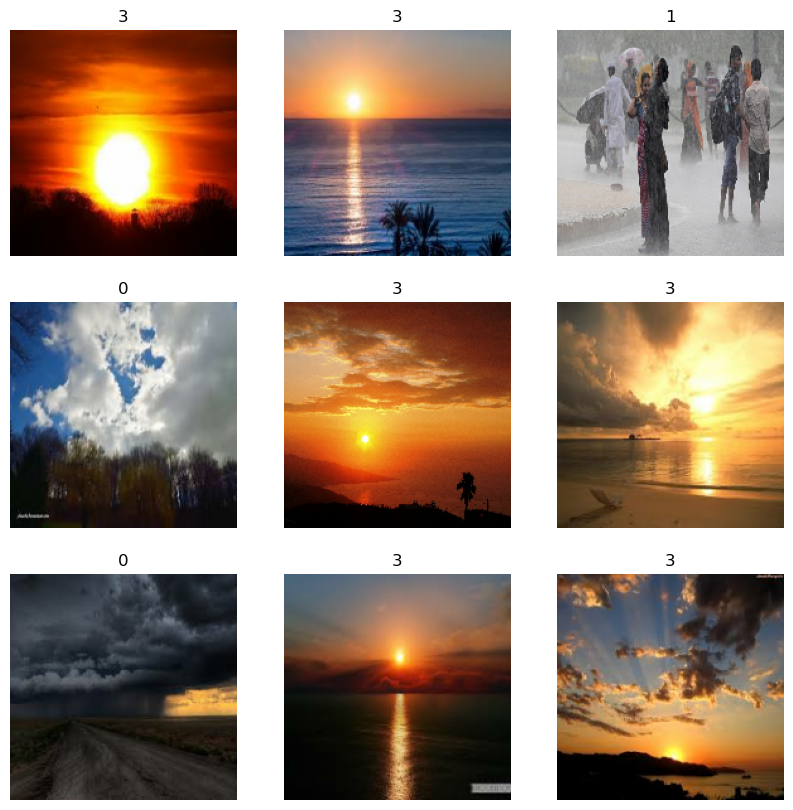

In [74]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [75]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

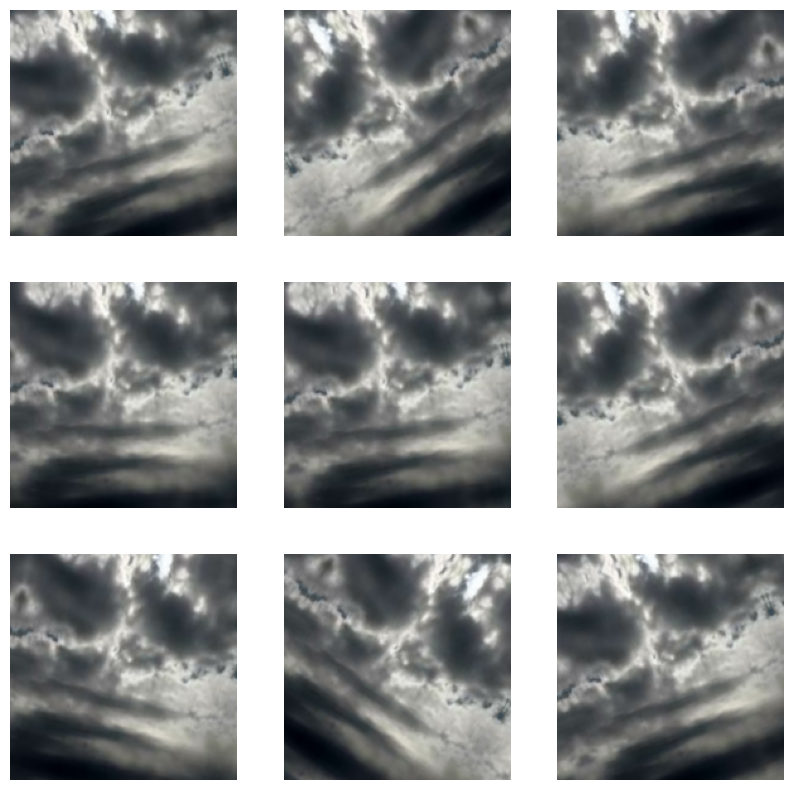

In [76]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [77]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [78]:
def make_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # Output
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)

In [79]:
model = make_model(input_shape=image_size + (3,), num_classes=4)

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_8         │ (None, 180, 180,  │          0 │ input_layer_8[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 90, 90,    │      3,584 │ rescaling_8[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │        512 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_64       │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_65       │ (None, 90, 90,    │          0 │ activation_64[0]… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_56 │ (None, 90, 90,    │     34,176 │ activation_65[0]… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_66       │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_57 │ (None, 90, 90,    │     68,096 │ activation_66[0]… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 45, 45,    │     33,024 │ activation_64[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 45, 45,    │          0 │ max_pooling2d_24… │
│                     │ 256)              │            │ conv2d_33[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_67       │ (None, 45, 45,    │          0 │ add_24[0][0]      │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_58 │ (None, 45, 45,    │    133,888 │ activation_67[0]… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │      2,048 │ separable_conv2d

 Total params: 2,734,140 (10.43 MB)

 Trainable params: 2,725,852 (10.40 MB)

 Non-trainable params: 8,288 (32.38 KB)

In [80]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # assumes integer labels
    metrics=["accuracy"],
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 76s 11s/step - accuracy: 0.7013 - loss: 0.7606 - val_accuracy: 0.2917 - val_loss: 1.3854
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 77s 11s/step - accuracy: 0.8604 - loss: 0.3765 - val_accuracy: 0.2870 - val_loss: 1.3840
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 76s 11s/step - accuracy: 0.8962 - loss: 0.2632 - val_accuracy: 0.2870 - val_loss: 1.3831
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 12s/step - accuracy: 0.9181 - loss: 0.2225 - val_accuracy: 0.2870 - val_loss: 1.3824
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 83s 12s/step - accuracy: 0.9158 - loss: 0.2005 - val_accuracy: 0.2870 - val_loss: 1.3818
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 83s 12s/step - accuracy: 0.9366 - loss: 0.1652 - val_accuracy: 0.2870 - val_loss: 1.3810
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 86s 12s/step - accuracy: 0.9469 - loss: 0.1425 - val_accuracy: 0.2870 - val_loss: 1.3810
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 86s 12s/step - accuracy: 0.9585 - loss: 0.1385 - val_accuracy: 0.2870 - val_loss: 1.3808


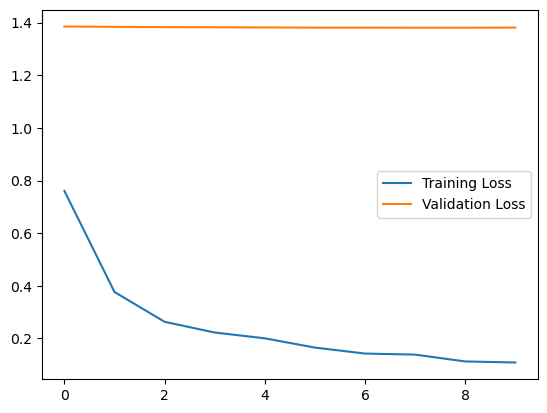

In [81]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

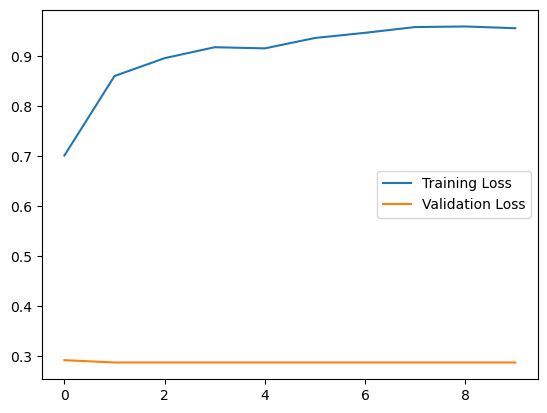

In [82]:
plt.plot(range(len(history.history["accuracy"])),history.history["accuracy"],label="Training Loss")
plt.plot(range(len(history.history["val_accuracy"])),history.history["val_accuracy"],label="Validation Loss")
plt.legend()